# Rolldown and carry

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from nss import NSS
from utils import dbObj

Select the dates for the holding period of the rolldown strategy. For this example we select a two year holding period and gilts with redemption date at least 20 years

In [2]:
d0 = '04-Nov-2014' 
d1 = '04-Nov-2016' 

Get some gilts as of 04-Nov-2014

In [3]:
sqlStr = " SELECT distinct ISIN_Code  FROM [Research].[dbo].[Gilts] "
sqlStr += " where Close_of_Business_Date = '%s' " % d0
sqlStr += " and datepart(year, Redemption_Date) >= 2034 "

In [4]:
engine = dbObj()
connection = engine.connect()
rs = pd.read_sql(sqlStr, connection)
connection.dispose()

Fetch the Nelson-Siegel-Svensson parameters to calculate the curve

In [5]:
sqlStr = " SELECT * FROM Research.dbo.nss_coeff nss where Date = '%s' " % d0
nss_coeff = pd.read_sql(sqlStr, connection, index_col=['Date'])
del nss_coeff.index.name
coeff = nss_coeff.loc[d0].values

Check the slope: If the 2yr yield is lower than the 10yr (which is usually the case) implement the rolldown strategy

In [6]:
nss = NSS(None, None)
two_yr = nss.yield_curve([2], coeff)
ten_yr = nss.yield_curve([10], coeff)

Do a plot of the yield curve

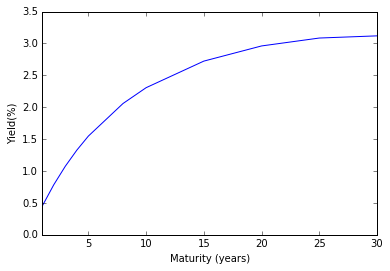

In [7]:
yc = 100*nss.yield_curve([1, 2, 3, 4, 5, 8, 10, 15, 20, 25, 30], coeff)
ax = yc.transpose().plot(legend=None)
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('Yield(%)')

For each gilt, calculate the return

In [8]:
if two_yr.values[0] < ten_yr.values[0]:
    sqlStr = " SELECT distinct g1.ISIN_Code, g1.Redemption_Date, "
    sqlStr += " g1.Close_of_Business_Date as Position_open_date, "
    sqlStr += " g2.Close_of_Business_Date as Position_close_date, "  
    sqlStr += " (g2.Dirty_Price/g1.Dirty_Price-1) as ret "
    sqlStr += " FROM [Research].[dbo].[Gilts] g1  "
    sqlStr += " JOIN [Research].[dbo].[Gilts] g2 "
    sqlStr += " ON g1.ISIN_Code = g2.ISIN_Code "
    sqlStr += " AND g1.Redemption_Date = g2.Redemption_Date "
    sqlStr += " AND g2.Close_of_Business_Date = '%s' " % d1
    sqlStr += " WHERE g1.Close_of_Business_Date = '%s' " % d0
    sqlStr += " AND datepart(year, g1.Redemption_Date) >= 2034 "
    sqlStr += " ORDER by ISIN_Code "
    
    rs = pd.read_sql(sqlStr, connection, index_col=['ISIN_Code'])
    

In [9]:
rs.head() #show the first few rows of the resultset above

,Redemption_Date,Position_open_date,Position_close_date,ret
ISIN_Code,,,,
GB0032727876,2036-03-07,2014-11-04,2016-11-04,0.329336
GB0032729583,2034-03-07,2014-11-04,2016-11-04,0.300164
GB0032729690,2034-09-07,2014-11-04,2016-11-04,0.307432
GB0032729708,2035-03-07,2014-11-04,2016-11-04,0.314620
GB0032729815,2035-09-07,2014-11-04,2016-11-04,0.321982


The mean return of the rolldown strategy (over the 2 year holding period) is:

In [10]:
"Return is %2.3f%%"  % (100*rs['ret'].mean())

'Return is 41.892%'

# Adjusting for duration

A rolldown strategy apart from expressing a view on the slope of the yield curve is also exposed to the level of the interest rates. To hedge against the duration risk we can create a portfolio which invests a part in an overnight cash account and the remaining in the rolldown gilt. For example, if we plan to close the trade after 24 months then the duration of the portfolio should match that of a 24 month gilt

$$D_{24m} = wD_{20yr} + (1-w)D_O$$

Hence: $$ w = \frac{D_{24m}-D_O}{D_{20yr}-D_O}$$

For gilt strips and as a simple study case, we can assume that the 2 year and 20 year durations are close to 2 and 20 respectively. The overnight cash account has a duration of zero therefore $$ w\approx \frac{2}{20} \approx  0.1$$

The excess returns when you take into account the duration hedge will be $R = [wR_{rolldown}+(1-w)R_{cash}] - R_{24m}$ where $R_{rolldown}$ is the return of the rolldown strategy, $R_{cash}$ the overnight cash account return compounded for the holding period (24 months in this case) and $R_{24m}$ the return of a 2 year gilt. We see that the hedge has a very drastic effect on the excess returns.